In [1]:
import numpy as np
import pandas as pd

# pd.set_option('display.height', 1000)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.set_option("max_colwidth", 200)
from IPython.core.display import HTML, display

display(HTML("<style>.container { width:100% !important; }</style>"))


import os

os.environ["R_HOME"] = "/root/miniconda3/envs/R/lib/R"

import rpy2.robjects as objects
from rpy2.robjects.packages import importr

base = importr("base")
r_pROC = importr("pROC")
base._libPaths()[0]


def df_stats(df):
    from tabulate import tabulate

    print("\n***** Shape: ", df.shape, " *****\n")

    columns_list = df.columns.values.tolist()
    isnull_list = df.isnull().sum().values.tolist()
    isunique_list = df.nunique().values.tolist()
    dtypes_list = df.dtypes.tolist()

    list_stat_val = list(zip(columns_list, isnull_list, isunique_list, dtypes_list))
    df_stat_val = pd.DataFrame(
        list_stat_val, columns=["Name", "Null", "Unique", "Dtypes"]
    )
    print(tabulate(df_stat_val, headers="keys", tablefmt="psql"))
    return df.head()

/tmp/ipykernel_110332/1622204394.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


In [112]:
# this is muse_xml_to_array.py
# Input a directory of XML files, get a directory of np arrays where each .npy is a 12-lead ecg shape 2500,12,1. So this gives you JUST the waveforms
# Some notes, the unique ECG ID index key used in MUSE backend does not exist in the XML at least for us, so instead we use MRN_AcquisitionDTTM_PharmaUniqueECGID

# In terminal run python3 muse_xml_to_array.py <LOCATION_OF_XML_FILES>

import argparse
import base64
import os
import struct
import sys

import numpy as np
import pandas as pd
import xmltodict


def file_path(path):
    filepath = path
    for dirName, subdirList, fileList in os.walk(filepath):
        for filename in fileList:
            if ".xml" in filename.lower():
                ekg_file_list.append(os.path.join(dirName, filename))


# need to update this function to check the output directory for the output file and then only on newly added EKGs
# add timestamp to start file string
# this is annoying because the XML file name is a random timestamp and the output file is the UniqueECGID


if not os.path.exists(os.getcwd() + "/ekg_waveforms_output/"):
    os.mkdir(os.getcwd() + "/ekg_waveforms_output/")

# parser = argparse.ArgumentParser(description='Input and outputs for XML EKG parsing')
# parser.add_argument('input', type=str)
# parser.set_defaults(output=os.getcwd() + '/ekg_waveforms_output/') #ensure this directory already exists

# args = parser.parse_args()


def decode_ekg_muse(raw_wave):
    """
    Ingest the base64 encoded waveforms and transform to numeric
    """
    # covert the waveform from base64 to byte array
    arr = base64.b64decode(bytes(raw_wave, "utf-8"))

    # unpack every 2 bytes, little endian (16 bit encoding)
    unpack_symbols = "".join([char * (len(arr) // 2) for char in "h"])
    byte_array = struct.unpack(unpack_symbols, arr)
    return byte_array


def decode_ekg_muse_to_array(raw_wave, downsample=1):
    """
    Ingest the base64 encoded waveforms and transform to numeric

    downsample: 0.5 takes every other value in the array. Muse samples at 500/s and the sample model requires 250/s. So take every other.
    """
    try:
        dwnsmpl = int(1 // downsample)
    except ZeroDivisionError:
        print("You must downsample by more than 0")
    # covert the waveform from base64 to byte array
    arr = base64.b64decode(bytes(raw_wave, "utf-8"))

    # unpack every 2 bytes, little endian (16 bit encoding)
    unpack_symbols = "".join([char * int(len(arr) / 2) for char in "h"])
    byte_array = struct.unpack(unpack_symbols, arr)
    return np.array(byte_array)[::dwnsmpl]


def xml_to_np_array_file(path_to_xml, path_to_output=os.getcwd()):

    with open(path_to_xml, "rb") as fd:
        dic = xmltodict.parse(fd.read().decode("utf8"))

    """
    
    Upload the ECG as numpy array with shape=[2500,12,1] ([time, leads, 1]).

    The voltage unit should be in 1 mv/unit and the sampling rate should be 250/second (total 10 second).

    The leads should be ordered as follow I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5, V6.

    """
    # print(dic)
    try:
        pt_id = dic["RestingECG"]["PatientDemographics"]["PatientID"]
    except:
        print("no PatientID")
        pt_id = "none"
    try:
        AcquisitionDateTime = (
            dic["RestingECG"]["TestDemographics"]["AcquisitionDate"]
            + "_"
            + dic["RestingECG"]["TestDemographics"]["AcquisitionTime"].replace(":", "-")
        )
    except:
        print("no AcquisitionDateTime")
        AcquisitionDateTime = "none"

    # try:
    #     requisition_number = dic['RestingECG']['Order']['RequisitionNumber']
    # except:
    #     print("no requisition_number")
    #     requisition_number = "none"

    # need to instantiate leads in the proper order for the model
    lead_order = [
        "I",
        "II",
        "III",
        "aVR",
        "aVL",
        "aVF",
        "V1",
        "V2",
        "V3",
        "V4",
        "V5",
        "V6",
    ]

    """
    Each EKG will have this data structure:
    lead_data = {
        'I': np.array
    }
    """

    lead_data = dict.fromkeys(lead_order)
    # lead_data = {leadid: None for k in lead_order}

    #     for all_lead_data in dic['RestingECG']['Waveform']:
    #         for single_lead_data in lead['LeadData']:
    #             leadname =  single_lead_data['LeadID']
    #             if leadname in (lead_order):
    #try:
        for lead in dic["RestingECG"]["Waveform"]:
            for leadid in range(len(lead["LeadData"])):
                sample_length = len(
                    decode_ekg_muse_to_array(lead["LeadData"][leadid]["WaveFormData"])
                )
                # sample_length is equivalent to dic['RestingECG']['Waveform']['LeadData']['LeadSampleCountTotal']
                if sample_length == 5000:
                    lead_data[
                        lead["LeadData"][leadid]["LeadID"]
                    ] = decode_ekg_muse_to_array(
                        lead["LeadData"][leadid]["WaveFormData"], downsample=0.5
                    )
                elif sample_length == 2500:
                    lead_data[
                        lead["LeadData"][leadid]["LeadID"]
                    ] = decode_ekg_muse_to_array(
                        lead["LeadData"][leadid]["WaveFormData"], downsample=1
                    )
                else:
                    continue
            # ensures all leads have 2500 samples and also passes over the 3 second waveform

        lead_data["III"] = np.array(lead_data["II"]) - np.array(lead_data["I"])
        lead_data["aVR"] = -(np.array(lead_data["I"]) + np.array(lead_data["II"])) / 2
        lead_data["aVF"] = (np.array(lead_data["II"]) + np.array(lead_data["III"])) / 2
        lead_data["aVL"] = (np.array(lead_data["I"]) - np.array(lead_data["III"])) / 2

        lead_data = {k: lead_data[k] for k in lead_order}
        # drops V3R, V4R, and V7 if it was a 15-lead ECG

        # now construct and reshape the array
        # converting the dictionary to an np.array
        temp = []
        for key, value in lead_data.items():
            temp.append(value)

        # transpose to be [time, leads, ]
        ekg_array = np.array(temp).T

        # expand dims to [time, leads, 1]
        ekg_array = np.expand_dims(ekg_array, axis=-1)

        # Here is a check to make sure all the model inputs are the right shape
        #     assert ekg_array.shape == (2500, 12, 1), "ekg_array is shape {} not (2500, 12, 1)".format(ekg_array.shape )

        # filename = '/ekg_waveform_{}_{}.npy'.format(pt_id, requisition_number)
        filename = f"{pt_id}_{AcquisitionDateTime}.npy"

        path_to_output += filename
        # print(path_to_output)
        with open(path_to_output, "wb") as f:
            np.save(f, ekg_array)
        return path_to_output

    #except:
    #    print("error", dic)
    #    return None


def ekg_batch_run(ekg_list):
    i = 0
    x = 0
    for file in ekg_list:
        try:
            xml_to_np_array_file(file, output_dir)
            i += 1
        except Exception as e:
            # print("file failed: ", file)
            print(file, e)
            x += 1
        if i % 10000 == 0:
            print(f"Succesfully converted {i} EKGs, failed converting {x} EKGs")

IndentationError: unexpected indent (3317527939.py, line 140)

In [113]:
def generate_ecg_dataframe_and_npy(df, output_dir="/ekg_waveforms_output/"):
    output_dir = os.getcwd() + output_dir

    from ECGXMLReader import ECGXMLReader
    from tqdm import tqdm

    patientid_list = []
    patientage_list = []
    patient_date_of_birth_list = []
    patient_gender_list = []
    patient_VentricularRate_list = []
    patient_AtrialRate_list = []
    patient_PRInterval_list = []
    patient_QRSDuration_list = []
    patient_QTInterval_list = []
    patient_QTCorrected_list = []
    patient_Paxis_list = []
    patient_Raxis_list = []
    patient_TAxis_list = []
    patient_QRSCount_list = []
    patient_QOnset_list = []
    patient_QOffset_list = []
    patient_POnset_list = []
    patient_POffset_list = []
    patient_TOffset_list = []
    patient_ECGSampleBase_list = []
    patient_ECGSampleExponent_list = []
    patient_QTcFrederica_list = []
    patient_Location_list = []
    patient_LocatioName_list = []
    patient_RoomID_list = []
    patient_acquisitiondate_list = []
    patient_acquisitiontime_list = []
    patient_status_list = []
    patient_acquisitiondevice_list = []
    patient_referringMDLastName_list = []
    patient_AnalysisSoftware_list = []
    patient_acquisitionSoftwareVersion_list = []
    diagnosis_list = []
    original_diagnosis_list = []
    ecg_output_path_list = []
    xml_path_list = []

    for index, row in tqdm(df.iterrows()):
        ecg = ECGXMLReader(row["path"], augmentLeads=True)
        xml_path_list.append(row["path"])
        ### Concatenate dictionary keys self.ECG['RestingECG']['Diagnosis'] into a list
        patientid_list.append(ecg.PatientDemographics["PatientID"])

        try:
            patientage_list.append(ecg.PatientDemographics["PatientAge"])
        except:
            patientage_list.append(np.nan)

        try:
            patient_date_of_birth_list.append(ecg.PatientDemographics["DateofBirth"])
        except:
            patient_date_of_birth_list.append(np.nan)
        try:
            patient_gender_list.append(ecg.PatientDemographics["Gender"])
        except:
            patient_gender_list.append(np.nan)

        try:
            patient_VentricularRate_list.append(
                ecg.RestingECGMeasurements["VentricularRate"]
            )
        except:
            patient_VentricularRate_list.append(np.nan)

        try:
            patient_AtrialRate_list.append(ecg.RestingECGMeasurements["AtrialRate"])
        except:
            patient_AtrialRate_list.append(np.nan)
        try:
            patient_PRInterval_list.append(ecg.RestingECGMeasurements["PRInterval"])
        except:
            patient_PRInterval_list.append(np.nan)
        try:
            patient_QRSDuration_list.append(ecg.RestingECGMeasurements["QRSDuration"])
        except:
            patient_QRSDuration_list.append(np.nan)
        try:
            patient_QTInterval_list.append(ecg.RestingECGMeasurements["QTInterval"])
        except:
            patient_QTInterval_list.append(np.nan)

        try:
            patient_QTCorrected_list.append(ecg.RestingECGMeasurements["QTCorrected"])
        except:
            patient_QTCorrected_list.append(np.nan)
        try:
            patient_Paxis_list.append(ecg.RestingECGMeasurements["PAxis"])
        except:
            patient_Paxis_list.append(np.nan)

        try:
            patient_Raxis_list.append(ecg.RestingECGMeasurements["RAxis"])
        except:
            patient_Raxis_list.append(np.nan)
        try:
            patient_TAxis_list.append(ecg.RestingECGMeasurements["TAxis"])
        except:
            patient_TAxis_list.append(np.nan)

        try:
            patient_QRSCount_list.append(ecg.RestingECGMeasurements["QRSCount"])
        except:
            patient_QRSCount_list.append(np.nan)
        try:
            patient_QOnset_list.append(ecg.RestingECGMeasurements["QOnset"])
        except:
            patient_QOnset_list.append(np.nan)

        try:
            patient_QOffset_list.append(ecg.RestingECGMeasurements["QOffset"])
        except:
            patient_QOffset_list.append(np.nan)
        try:
            patient_POnset_list.append(ecg.RestingECGMeasurements["POnset"])
        except:
            patient_POnset_list.append(np.nan)
        try:
            patient_POffset_list.append(ecg.RestingECGMeasurements["POffset"])
        except:
            patient_POffset_list.append(np.nan)
        try:
            patient_TOffset_list.append(ecg.RestingECGMeasurements["TOffset"])
        except:
            patient_TOffset_list.append(np.nan)

        patient_ECGSampleBase_list.append(ecg.RestingECGMeasurements["ECGSampleBase"])
        patient_ECGSampleExponent_list.append(
            ecg.RestingECGMeasurements["ECGSampleExponent"]
        )
        try:
            patient_QTcFrederica_list.append(ecg.RestingECGMeasurements["QTcFrederica"])
        except:
            patient_QTcFrederica_list.append(np.nan)

        patient_Location_list.append(ecg.TestDemographics["Location"])

        try:
            patient_LocatioName_list.append(ecg.TestDemographics["LocationName"])
        except:
            patient_LocatioName_list.append(np.nan)

        try:
            patient_RoomID_list.append(ecg.TestDemographics["RoomID"])
        except:
            patient_RoomID_list.append("None")
        try:
            patient_acquisitiondate_list.append(ecg.TestDemographics["AcquisitionDate"])
        except:
            patient_acquisitiondate_list.append(np.nan)

        try:
            patient_acquisitiontime_list.append(ecg.TestDemographics["AcquisitionTime"])
        except:
            patient_acquisitiontime_list.append(np.nan)

        patient_status_list.append(ecg.TestDemographics["Status"])

        try:
            patient_acquisitiondevice_list.append(
                ecg.TestDemographics["AcquisitionDevice"]
            )
        except:
            patient_acquisitiondevice_list.append(np.nan)

        try:
            patient_referringMDLastName_list.append(
                ecg.TestDemographics["ReferringMDLastName"]
            )
        except:
            patient_referringMDLastName_list.append("None")
        try:
            patient_AnalysisSoftware_list.append(
                ecg.TestDemographics["AnalysisSoftwareVersion"]
            )
        except:
            patient_AnalysisSoftware_list.append(np.nan)
        try:
            patient_acquisitionSoftwareVersion_list.append(
                ecg.TestDemographics["AcquisitionSoftwareVersion"]
            )
        except:
            patient_acquisitionSoftwareVersion_list.append(np.nan)

        diagnosis = []
        try:
            for key in ecg.Diagnosis["DiagnosisStatement"]:
                # print(key['StmtText'])
                try:
                    diagnosis.append(key["StmtText"])
                except:
                    diagnosis.append(key["ENDSLINE"])

            ##merge items in diagnosis list into a single string
            diagnosis = " ".join(diagnosis)

            diagnosis_list.append(diagnosis)
        except:
            print(ecg.TestDemographics)
            print(ecg.PatientDemographics)
            print(ecg.RestingECGMeasurements)
            print(ecg.PatientDemographics["PatientID"])
            diagnosis_list.append(-1)

        diagnosis = []
        try:
            for key in ecg.OriginalDiagnosis["DiagnosisStatement"]:
                # print(key['StmtText'])
                try:
                    diagnosis.append(key["StmtText"])
                except:
                    diagnosis.append(key["ENDSLINE"])

            ##merge items in diagnosis list into a single string
            diagnosis = " ".join(diagnosis)

            original_diagnosis_list.append(diagnosis)
        except:
            print(ecg.TestDemographics)
            print(ecg.PatientDemographics)
            print(ecg.RestingECGMeasurements)
            print(ecg.PatientDemographics["PatientID"])
            original_diagnosis_list.append(-1)

            # display(ecg.Diagnosis['DiagnosisStatement'])
            # break
        # print(ecg.TestDemographics)
        # print(ecg.PatientDemographics)
        # print(ecg.RestingECGMeasurements)
        # print(ecg.Diagnosis)
        # print(ecg.OriginalDiagnosis)
        ecg_output_path = xml_to_np_array_file(row["path"], output_dir)
        ecg_output_path_list.append(ecg_output_path)
    ##Create dataaframe with the previous lists
    df_output = pd.DataFrame(
        {
            "patientid": patientid_list,
            "age": patientage_list,
            "dob": patient_date_of_birth_list,
            "gender": patient_gender_list,
            "VentricularRate": patient_VentricularRate_list,
            "AtrialRate": patient_AtrialRate_list,
            "PRInterval": patient_PRInterval_list,
            "QRSDuration": patient_QRSDuration_list,
            "QTInterval": patient_QTInterval_list,
            "QTCorrected": patient_QTCorrected_list,
            "PAxis": patient_Paxis_list,
            "RAXis": patient_Raxis_list,
            "TAxis": patient_TAxis_list,
            "QRSCount": patient_QRSCount_list,
            "QOnset": patient_QOnset_list,
            "QOffset": patient_QOffset_list,
            "POnset": patient_POnset_list,
            "POffset": patient_POffset_list,
            "TOffset": patient_TOffset_list,
            "ECGSampleBase": patient_ECGSampleBase_list,
            "ECGSampleExponent": patient_ECGSampleExponent_list,
            "QTcFrederica": patient_QTcFrederica_list,
            "Location": patient_Location_list,
            "LocationName": patient_LocatioName_list,
            "RoomID": patient_RoomID_list,
            "AcquisitionDate": patient_acquisitiondate_list,
            "AcquisitionTime": patient_acquisitiontime_list,
            "Status": patient_status_list,
            "AcquisitionDevice": patient_acquisitiondevice_list,
            "ReferringMDLastName": patient_referringMDLastName_list,
            "AnalysisSoftware": patient_AnalysisSoftware_list,
            "AcquisitionSoftwareVersion": patient_acquisitionSoftwareVersion_list,
            "Diagnosis": diagnosis_list,
            "Original_Diagnosis": original_diagnosis_list,
            "xml_path": xml_path_list,
            "ecg_output_path": ecg_output_path_list,
        }
    )
    return df_output

In [4]:
### List all files in '/media/data1/muse_ge/ecg_retrospective' ending in XML and add them to list
import glob
import os

## Get all fins in directory 'media/data1/muse_ge/ecg_retrospective' ending in .XML
path = "/media/data1/muse_ge/ecg_retrospective"
all_files = glob.glob(os.path.join(path, "*.xml"))
### Create dataframe with all ECG files
df = pd.DataFrame(all_files, columns=["path"])
display(df)

# 1711846 files as of 2022

,path
0,/media/data1/muse_ge/ecg_retrospective/MUSE_20230228_072022_57000.xml
1,/media/data1/muse_ge/ecg_retrospective/MUSE_20230228_071051_67000.xml
2,/media/data1/muse_ge/ecg_retrospective/MUSE_20230228_074332_83000.xml
3,/media/data1/muse_ge/ecg_retrospective/MUSE_20220622_120345_21000.xml
4,/media/data1/muse_ge/ecg_retrospective/MUSE_20220712_143133_74000.xml
...,...
1633851,/media/data1/muse_ge/ecg_retrospective/MUSE_20230224_121943_13000.xml
1633852,/media/data1/muse_ge/ecg_retrospective/MUSE_20230224_132348_92000.xml
1633853,/media/data1/muse_ge/ecg_retrospective/MUSE_20230227_120955_38000.xml
1633854,/media/data1/muse_ge/ecg_retrospective/MUSE_20230227_121045_77000.xml


In [19]:
df.to_csv("data/20230313_ECG_path.csv")

In [5]:
# df_output = generate_ecg_dataframe_and_npy(df)
# df_output.to_csv("data/20221002_ECG.csv")
# df_output = pd.read_csv("data/20221002_ECG_mod_diagnosis.csv")
# display(df_output.describe())

/tmp/ipykernel_4841/3169193681.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_output = pd.read_csv("data/20221002_ECG_mod_diagnosis.csv")


,Unnamed: 0.1,Unnamed: 0,age,VentricularRate,AtrialRate,PRInterval,QRSDuration,QTInterval,QTCorrected,PAxis,RAXis,TAxis,QRSCount,QOnset,QOffset,POnset,POffset,TOffset,ECGSampleBase,ECGSampleExponent,QTcFrederica,Location,ecg_abnormal
count,235533.000000,235533.000000,235424.000000,235517.000000,227456.000000,190063.000000,235521.000000,235520.000000,235517.000000,188026.000000,235518.000000,235521.000000,235477.000000,235476.000000,235476.000000,187729.000000,187729.000000,235476.000000,235533.000000,235533.0,235518.000000,235533.000000,235533.000000
mean,117766.000000,117766.000000,65.597649,73.235473,83.241990,173.786487,105.699152,411.309885,446.106098,48.357935,18.405786,53.573792,12.055670,214.938189,267.790306,130.987514,182.876130,420.597696,499.988324,0.0,433.793400,28.530703,-0.751848
std,67992.664814,67992.664814,15.435632,18.177965,53.585095,337.715864,29.597543,51.395899,43.957990,28.384298,57.986174,59.670323,3.012264,10.946508,12.105846,20.741673,21.199489,24.882813,1.708446,0.0,41.075763,70.440360,0.431941
min,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-89.000000,-89.000000,-89.000000,0.000000,0.000000,0.000000,0.000000,35.000000,0.000000,250.000000,0.0,0.000000,-1.000000,-1.000000
25%,58883.000000,58883.000000,57.000000,61.000000,61.000000,148.000000,86.000000,380.000000,418.000000,34.000000,-18.000000,18.000000,10.000000,212.000000,261.000000,121.000000,174.000000,407.000000,500.000000,0.0,408.000000,21.000000,-1.000000
50%,117766.000000,117766.000000,68.000000,70.000000,70.000000,166.000000,96.000000,408.000000,440.000000,51.000000,12.000000,44.000000,12.000000,217.000000,265.000000,134.000000,187.000000,420.000000,500.000000,0.0,427.000000,25.000000,-1.000000
75%,176649.000000,176649.000000,77.000000,81.000000,83.000000,188.000000,116.000000,440.000000,469.000000,64.000000,47.000000,80.000000,13.000000,221.000000,272.000000,145.000000,197.000000,435.000000,500.000000,0.0,454.000000,42.000000,-1.000000
max,235532.000000,235532.000000,106.000000,281.000000,833.000000,65534.000000,356.000000,778.000000,910.000000,270.000000,270.000000,270.000000,40.000000,247.000000,349.000000,227.000000,259.000000,595.000000,500.000000,0.0,863.000000,33341.000000,0.000000


In [9]:
# df_output['ecg_abnormal'] = np.where(df_output['Diagnosis'].str.contains('ECG anormal'), 1, np.where(df_output['Diagnosis'].str.contains('ECG normal'), 0, -1))
# Remove ECG anormal and ECG normal from diagnosis
# df_output['Diagnosis'] = df_output['Diagnosis'].str.replace('ECG anormal', '')
# df_output['Original_Diagnosis'] = df_output['Original_Diagnosis'].str.replace('ECG normal', '')
# df_output['Original_Diagnosis'] = df_output['Diagnosis'].str.replace('ECG anormal', '')
# df_output['Diagnosis'] = df_output['Original_Diagnosis'].str.replace('ECG normal', '')
# df_output.to_csv('data/20221002_ECG_mod_diagnosis.csv')

In [10]:
display(df_output.ecg_abnormal.value_counts())

-1    177085
 0     58448
Name: ecg_abnormal, dtype: int64

In [11]:
df_m = (
    df_output.groupby(["patientid", "AcquisitionDate", "AcquisitionTime"])
    .first()
    .reset_index()
)
display(df_stats(df_output))
display(df_stats(df_m))
## The ECGs can be grouped by patient id, date and time to have a 1 unique row per ECG - this means the filename to save the ECG also needs to have the date and time in it.


***** Shape:  (235533, 38)  *****

+----+----------------------------+--------+----------+----------+
|    | Name                       |   Null |   Unique | Dtypes   |
|----+----------------------------+--------+----------+----------|
|  0 | Unnamed: 0                 |      0 |   235533 | int64    |
|  1 | patientid                  |      0 |    68198 | object   |
|  2 | age                        |    109 |       99 | float64  |
|  3 | dob                        |   1919 |    22444 | object   |
|  4 | gender                     |     49 |        2 | object   |
|  5 | VentricularRate            |     16 |      215 | float64  |
|  6 | AtrialRate                 |   8077 |      336 | float64  |
|  7 | PRInterval                 |  45470 |      241 | float64  |
|  8 | QRSDuration                |     12 |      146 | float64  |
|  9 | QTInterval                 |     13 |      332 | float64  |
| 10 | QTCorrected                |     16 |      615 | float64  |
| 11 | PAxis              

,Unnamed: 0,patientid,age,dob,gender,VentricularRate,AtrialRate,PRInterval,QRSDuration,QTInterval,QTCorrected,PAxis,RAXis,TAxis,QRSCount,QOnset,QOffset,POnset,POffset,TOffset,ECGSampleBase,ECGSampleExponent,QTcFrederica,Location,LocationName,RoomID,AcquisitionDate,AcquisitionTime,Status,AcquisitionDevice,ReferringMDLastName,AnalysisSoftware,AcquisitionSoftwareVersion,Diagnosis,Original_Diagnosis,xml_path,ecg_output_path,ecg_abnormal
0,0,0604777,74.0,07-18-1947,MALE,76.0,76.0,168.0,100.0,400.0,450.0,79.0,31.0,20.0,13.0,220.0,270.0,136.0,189.0,420.0,500,0,432.0,33,3 NORD,61,06-22-2022,21:34:54,UNCONFIRMED,MV360,DR.BOUCHARD,243,1.02 SP02,Rythme sinusal avec de rare(s) complexes AV à rythme entrainé sequentiel Criteres de voltage limites d'HVG ou variante de la normale ( Sokolow-Lyon ) Anomalie non-spécifique du segment ST,Rythme sinusal avec de rare(s) complexes AV à rythme entrainé sequentiel Criteres de voltage limites d'HVG ou variante de la normale ( Sokolow-Lyon ) Anomalie non-spécifique du segment ST,/media/data1/muse_ge/ecg_retrospective/MUSE_20220712_143132_57000.xml,/volume/DeepECG/ekg_waveforms_output/0604777_06-22-2022_21-34-54.npy,-1
1,1,0799999,81.0,06-21-1940,MALE,60.0,60.0,164.0,82.0,382.0,382.0,44.0,46.0,47.0,9.0,220.0,261.0,138.0,181.0,411.0,500,0,382.0,1,1_CARDIOLOGIE GENERALE,None,08-13-2021,11:01:03,CONFIRMED,MV360,Md I.C.M.,243,1.02 SP01,"Rythme sinusal normal Rapport R/S augmenté en V1, considérer rotation horaire ou infarctus postérieur","Rythme sinusal normal Rapport R/S augmenté en V1, considérer rotation horaire ou infarctus postérieur",/media/data1/muse_ge/ecg_retrospective/MUSE_20220622_120344_07000.xml,/volume/DeepECG/ekg_waveforms_output/0799999_08-13-2021_11-01-03.npy,-1
2,2,0609146,38.0,09-30-1983,MALE,185.0,NaN,NaN,78.0,266.0,466.0,NaN,145.0,20.0,31.0,216.0,255.0,NaN,NaN,349.0,500,0,387.0,43,4 NORD,456,06-22-2022,21:20:00,UNCONFIRMED,MV360,None,243,1.02 SP02,*** ATTENTION! mauvaise qualité de l'ECG*** Tachycardie supraventriculaire Hypertrophie ventriculaire droite,*** ATTENTION! mauvaise qualité de l'ECG*** Tachycardie supraventriculaire Hypertrophie ventriculaire droite,/media/data1/muse_ge/ecg_retrospective/MUSE_20220712_143134_90000.xml,/volume/DeepECG/ekg_waveforms_output/0609146_06-22-2022_21-20-00.npy,-1
3,3,0799999,81.0,06-21-1940,MALE,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,500,0,0.0,1,1_CARDIOLOGIE GENERALE,None,08-19-2021,14:15:00,CONFIRMED,MV360,Md I.C.M.,243,1.02 SP01,-1,-1,/media/data1/muse_ge/ecg_retrospective/MUSE_20220622_120345_21000.xml,/volume/DeepECG/ekg_waveforms_output/0799999_08-19-2021_14-15-00.npy,-1
4,4,0609083,66.0,07-05-1955,MALE,53.0,53.0,172.0,148.0,452.0,424.0,54.0,-48.0,61.0,8.0,211.0,285.0,125.0,171.0,437.0,500,0,433.0,51,5 COURT-SEJOUR,502-5,06-22-2022,22:51:54,UNCONFIRMED,MV360,None,243,1.02 SP02,Bradycardie sinusale Bloc de branche droit complet Hémibloc antérieur gauche *** Bloc bifasiculaire ***,Bradycardie sinusale Bloc de branche droit complet Hémibloc antérieur gauche *** Bloc bifasiculaire ***,/media/data1/muse_ge/ecg_retrospective/MUSE_20220712_143133_74000.xml,/volume/DeepECG/ekg_waveforms_output/0609083_06-22-2022_22-51-54.npy,-1



***** Shape:  (208644, 38)  *****

+----+----------------------------+--------+----------+----------+
|    | Name                       |   Null |   Unique | Dtypes   |
|----+----------------------------+--------+----------+----------|
|  0 | patientid                  |      0 |    68198 | object   |
|  1 | AcquisitionDate            |      0 |      955 | object   |
|  2 | AcquisitionTime            |      0 |    59510 | object   |
|  3 | Unnamed: 0                 |      0 |   208644 | int64    |
|  4 | age                        |     69 |       99 | float64  |
|  5 | dob                        |   1542 |    22444 | object   |
|  6 | gender                     |     36 |        2 | object   |
|  7 | VentricularRate            |     16 |      215 | float64  |
|  8 | AtrialRate                 |   4575 |      336 | float64  |
|  9 | PRInterval                 |  38185 |      241 | float64  |
| 10 | QRSDuration                |     12 |      146 | float64  |
| 11 | QTInterval         

,patientid,AcquisitionDate,AcquisitionTime,Unnamed: 0,age,dob,gender,VentricularRate,AtrialRate,PRInterval,QRSDuration,QTInterval,QTCorrected,PAxis,RAXis,TAxis,QRSCount,QOnset,QOffset,POnset,POffset,TOffset,ECGSampleBase,ECGSampleExponent,QTcFrederica,Location,LocationName,RoomID,Status,AcquisitionDevice,ReferringMDLastName,AnalysisSoftware,AcquisitionSoftwareVersion,Diagnosis,Original_Diagnosis,xml_path,ecg_output_path,ecg_abnormal
0,74,11-08-2021,06:44:43,87194,74.0,None,MALE,37.0,37.0,174.0,90.0,518.0,406.0,57.0,9.0,-4.0,7.0,210.0,255.0,123.0,179.0,469.0,500,0,441.0,22,22_URGENCE MAJEURE,A11,CONFIRMED,MAC55,None,239,009C,Bradycardie sinusale marquée,Bradycardie sinusale marquée,/media/data1/muse_ge/ecg_retrospective/MUSE_20220907_233630_79000.xml,/volume/DeepECG/ekg_waveforms_output/0000074_11-08-2021_06-44-43.npy,-1
1,138,10-15-2021,12:13:39,93574,72.0,01-26-1949,FEMALE,62.0,62.0,150.0,86.0,428.0,434.0,84.0,22.0,37.0,11.0,219.0,262.0,144.0,177.0,433.0,500,0,432.0,1,1_CARDIOLOGIE GENERALE,None,CONFIRMED,MAC55,Md I.C.M.,239,009C,Rythme sinusal normal,Rythme sinusal normal ECG normal,/media/data1/muse_ge/ecg_retrospective/MUSE_20220910_220003_77000.xml,/volume/DeepECG/ekg_waveforms_output/0000138_10-15-2021_12-13-39.npy,0
2,907,11-17-2021,10:22:22,84445,75.0,03-07-1946,FEMALE,97.0,97.0,NaN,132.0,406.0,515.0,NaN,112.0,-27.0,15.0,232.0,298.0,NaN,NaN,435.0,500,0,476.0,1,1_CARDIOLOGIE GENERALE,None,CONFIRMED,MAC55,Md Référant M-V,239,009C,Cardio-stimulateur à demande; interprétation basée sur le rythme spontané Fibrillation auriculaire avec extrasystoles ventriculaires ou extrasystoles avec conduction aberrante Bloc de branche droi...,Cardio-stimulateur à demande; interprétation basée sur le rythme spontané Fibrillation auriculaire avec extrasystoles ventriculaires ou extrasystoles avec conduction aberrante Bloc de branche droi...,/media/data1/muse_ge/ecg_retrospective/MUSE_20220907_220841_82000.xml,/volume/DeepECG/ekg_waveforms_output/0000907_11-17-2021_10-22-22.npy,-1
3,1205,10-15-2021,08:52:31,93704,56.0,08-17-1965,FEMALE,77.0,77.0,148.0,164.0,456.0,516.0,43.0,84.0,19.0,13.0,215.0,297.0,141.0,189.0,443.0,500,0,495.0,2,2_CLINIQUE DES CONGENITAUX,None,CONFIRMED,MAC55,Md Référant M-V,239,009C,Rythme sinusal normal Bloc de branche droit complet Anomalie de l'onde T; ischémie inférolatérale possible,Rythme sinusal normal Bloc de branche droit complet Anomalie de l'onde T; ischémie inférolatérale possible,/media/data1/muse_ge/ecg_retrospective/MUSE_20220910_220256_82000.xml,/volume/DeepECG/ekg_waveforms_output/0001205_10-15-2021_08-52-31.npy,-1
4,1207,10-08-2021,12:42:17,95297,75.0,06-16-1946,MALE,57.0,57.0,248.0,110.0,438.0,426.0,61.0,32.0,66.0,9.0,215.0,270.0,91.0,159.0,434.0,500,0,430.0,1,1_CARDIOLOGIE GENERALE,None,CONFIRMED,MAC55,Md Référant M-V,239,009C,Bradycardie sinusale avec bloc A-V du premier degré par ailleurs,Bradycardie sinusale avec bloc A-V du premier degré ECG normal par ailleurs,/media/data1/muse_ge/ecg_retrospective/MUSE_20220910_223734_51000.xml,/volume/DeepECG/ekg_waveforms_output/0001207_10-08-2021_12-42-17.npy,0


In [12]:
# output_dir = os.getcwd() + '/ekg_waveforms_output/'
# ekg_batch_run(df['path'][0:1])

In [17]:
## Display top 1000 most frequent df_output['Diagnosis]
display(df_output["Diagnosis"].value_counts()[0:1000])

Rythme sinusal normal                                                                                                                                             34361
Bradycardie sinusale  par ailleurs                                                                                                                                 9350
-1                                                                                                                                                                 7532
Rythme sinusal normal Anomalie non-spécifique de l'onde T                                                                                                          2828
Rythme sinusal normal avec arythmie sinusale                                                                                                                       2535
                                                                                                                                                                

### Alexis Script

In [2]:
import numpy as np
import pandas as pd

# pd.set_option('display.height', 1000)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.set_option("max_colwidth", 200)
from IPython.core.display import HTML, display

display(HTML("<style>.container { width:100% !important; }</style>"))


import os

os.environ["R_HOME"] = "/root/miniconda3/envs/R/lib/R"

import rpy2.robjects as objects
from rpy2.robjects.packages import importr

base = importr("base")
r_pROC = importr("pROC")
base._libPaths()[0]


def df_stats(df):
    from tabulate import tabulate

    print("\n***** Shape: ", df.shape, " *****\n")

    columns_list = df.columns.values.tolist()
    isnull_list = df.isnull().sum().values.tolist()
    isunique_list = df.nunique().values.tolist()
    dtypes_list = df.dtypes.tolist()

    list_stat_val = list(zip(columns_list, isnull_list, isunique_list, dtypes_list))
    df_stat_val = pd.DataFrame(
        list_stat_val, columns=["Name", "Null", "Unique", "Dtypes"]
    )
    print(tabulate(df_stat_val, headers="keys", tablefmt="psql"))
    return df.head()

/tmp/ipykernel_110332/2095371957.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


In [5]:
df = pd.read_csv("data/20230313_ECG_path.csv")

In [ ]:
import CLI_xml2df as xml2df

df_output = xml2df.tinyxml2df(
    df["path"], out_path="data/ekg_waveforms_output/"
).read2flatten()

Transforming xml files into dict:   0%|                                                                                                                                                                                                                                                                                              | 61/1633856 [00:00<4:39:57, 97.26it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0799999', 'PatientAge': '81', 'AgeUnits': 'YEARS', 'DateofBirth': '06-21-1940', 'Gender': 'MALE', 'PatientLastName': 'MEDISOL', 'PatientFirstName': 'TEST'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '1', 'LocationName': '1_CARDIOLOGIE GENERALE', 'AcquisitionTime': '14:30:57', 'AcquisitionDate': '11-01-2021', 'EditTime': '10:57:44', 'EditDate': '11-02-2021', 'OverreaderID': '20001', 'EditorID': '4846', 'OrderingMDLastName': 'Md I.C.M.', 'OrderingMDFirstName': 'A Confirmer', 'ReferringMDLastName': 'Md I.C.M.', 'ReferringMDFirstName': 'A Confirmer', 'OverreaderLastName': 'MuseAdmin', 'OverreaderFirstName': 'MuseAdmin', 'EditorLastName': 'PELLERIN', 'EditorFirstName': 'SANDRA', 'HISStatus': '2'}, 'Order': {'RequisitionNumber': '21109084', '

Transforming xml files into dict:   4%|████████████▎                                                                                                                                                                                                                                                                              | 71436/1633856 [17:45<4:51:53, 89.21it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0799995', 'PatientAge': '65', 'AgeUnits': 'YEARS', 'DateofBirth': '04-05-1956', 'Gender': 'MALE', 'PatientLastName': 'MEDISOL', 'PatientFirstName': 'TESTPRENOM'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '1', 'LocationName': '1_CARDIOLOGIE GENERALE', 'AcquisitionTime': '17:08:26', 'AcquisitionDate': '12-04-2021', 'EditTime': '17:08:50', 'EditDate': '12-04-2021', 'OverreaderID': '20001', 'EditorID': '20001', 'OrderingMDLastName': 'Md I.C.M.', 'OrderingMDFirstName': 'A Confirmer', 'ReferringMDLastName': 'Md I.C.M.', 'ReferringMDFirstName': 'A Confirmer', 'OverreaderLastName': 'MuseAdmin', 'OverreaderFirstName': 'MuseAdmin', 'EditorLastName': 'MuseAdmin', 'EditorFirstName': 'MuseAdmin', 'HISStatus': '2'}, 'Order': {'RequisitionNumber': '2

Transforming xml files into dict:   5%|█████████████▊                                                                                                                                                                                                                                                                             | 79783/1633856 [19:18<4:49:40, 89.41it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0799995', 'PatientAge': '65', 'AgeUnits': 'YEARS', 'DateofBirth': '04-05-1956', 'Gender': 'MALE', 'PatientLastName': 'MEDISOL', 'PatientFirstName': 'TESTPRENOM'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '1', 'LocationName': '1_CARDIOLOGIE GENERALE', 'AcquisitionTime': '10:05:24', 'AcquisitionDate': '11-02-2021', 'EditTime': '10:05:55', 'EditDate': '11-02-2021', 'OverreaderID': '6666', 'EditorID': '20001', 'OrderingMDLastName': 'Md I.C.M.', 'OrderingMDFirstName': 'A Confirmer', 'ReferringMDLastName': 'Md I.C.M.', 'ReferringMDFirstName': 'A Confirmer', 'OverreaderLastName': 'NON VALIDÉ', 'OverreaderFirstName': 'PRELIMINAIRE', 'EditorLastName': 'MuseAdmin', 'EditorFirstName': 'MuseAdmin', 'HISStatus': '2'}, 'Order': {'RequisitionNumber':

Transforming xml files into dict:   5%|█████████████▊                                                                                                                                                                                                                                                                            | 80010/1633856 [19:20<4:18:38, 100.13it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0799999', 'PatientAge': '81', 'AgeUnits': 'YEARS', 'DateofBirth': '06-21-1940', 'Gender': 'MALE', 'PatientLastName': 'MEDISOL', 'PatientFirstName': 'TEST'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '1', 'LocationName': '1_CARDIOLOGIE GENERALE', 'AcquisitionTime': '14:30:57', 'AcquisitionDate': '11-01-2021', 'EditTime': '10:57:44', 'EditDate': '11-02-2021', 'OverreaderID': '20001', 'EditorID': '4846', 'OrderingMDLastName': 'Md I.C.M.', 'OrderingMDFirstName': 'A Confirmer', 'ReferringMDLastName': 'Md I.C.M.', 'ReferringMDFirstName': 'A Confirmer', 'OverreaderLastName': 'MuseAdmin', 'OverreaderFirstName': 'MuseAdmin', 'EditorLastName': 'PELLERIN', 'EditorFirstName': 'SANDRA', 'HISStatus': '2'}, 'Order': {'RequisitionNumber': '21109084', '

Transforming xml files into dict:   5%|█████████████▉                                                                                                                                                                                                                                                                             | 80789/1633856 [19:29<5:02:51, 85.47it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0192513', 'PatientAge': '85', 'AgeUnits': 'YEARS', 'DateofBirth': '07-09-1936', 'Gender': 'MALE', 'PatientLastName': 'MURO', 'PatientFirstName': 'VITO'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '8', 'LocationName': '8_BUREAU PRIVE DE MEDECIN', 'AcquisitionTime': '14:23:38', 'AcquisitionDate': '10-28-2021', 'EditTime': '15:18:29', 'EditDate': '10-28-2021', 'OverreaderID': '6666', 'EditorID': '3217', 'OverreaderLastName': 'NON VALIDÉ', 'OverreaderFirstName': 'PRELIMINAIRE', 'EditorLastName': 'DESAUTELS', 'EditorFirstName': 'VALÉRIE', 'HISStatus': '0'}, 'RestingECGMeasurements': {'ECGSampleBase': '250', 'ECGSampleExponent': '0'}, 'OriginalRestingECGMeasurements': {'ECGSampleBase': '250', 'ECGSampleExponent': '0'}, 'Diagnosis': {'Modality

Transforming xml files into dict:   7%|█████████████████████                                                                                                                                                                                                                                                                     | 121791/1633856 [27:10<4:30:27, 93.18it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0799999', 'PatientAge': '80', 'AgeUnits': 'YEARS', 'DateofBirth': '06-21-1940', 'Gender': 'MALE', 'PatientLastName': 'MEDISOL', 'PatientFirstName': 'TEST'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '30', 'LocationName': '30_ECG ICM SANS CONSULTATION', 'AcquisitionTime': '10:50:53', 'AcquisitionDate': '04-15-2021', 'EditTime': '14:07:35', 'EditDate': '04-15-2021', 'OverreaderID': '6666', 'AcquisitionTechID': '4846', 'EditorID': '4846', 'TestReason': 'TEST.', 'OrderingMDLastName': 'Md I.C.M.', 'OrderingMDFirstName': 'A Confirmer', 'ReferringMDLastName': 'Md I.C.M.', 'ReferringMDFirstName': 'A Confirmer', 'OverreaderLastName': 'NON VALIDÉ', 'OverreaderFirstName': 'PRELIMINAIRE', 'AcquisitionTechLastName': 'PELLERIN', 'AcquisitionTechFirst

Transforming xml files into dict:   8%|█████████████████████▎                                                                                                                                                                                                                                                                    | 123494/1633856 [27:29<4:22:16, 95.98it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0476353', 'PatientAge': '85', 'AgeUnits': 'YEARS', 'DateofBirth': '05-12-1935', 'Gender': 'MALE', 'PatientLastName': 'MEDISOL', 'PatientFirstName': 'MARIE'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '30', 'LocationName': '30_ECG ICM SANS CONSULTATION', 'AcquisitionTime': '11:13:16', 'AcquisitionDate': '04-07-2021', 'EditTime': '11:47:39', 'EditDate': '04-07-2021', 'OverreaderID': '6666', 'EditorID': '4846', 'TestReason': '.', 'OrderingMDLastName': 'Md Référant M-V', 'OrderingMDFirstName': '.', 'ReferringMDLastName': 'Md Référant M-V', 'ReferringMDFirstName': '.', 'OverreaderLastName': 'NON VALIDÉ', 'OverreaderFirstName': 'PRELIMINAIRE', 'EditorLastName': 'PELLERIN', 'EditorFirstName': 'SANDRA', 'HISStatus': '2'}, 'Order': {'Requisition

Transforming xml files into dict:   9%|████████████████████████▍                                                                                                                                                                                                                                                                 | 141591/1633856 [30:51<4:26:10, 93.44it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0480695', 'PatientAge': '60', 'AgeUnits': 'YEARS', 'DateofBirth': '12-13-1960', 'Gender': 'MALE', 'PatientLastName': 'TEST', 'PatientFirstName': 'TEST'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '1', 'LocationName': '1_CARDIOLOGIE GENERALE', 'AcquisitionTime': '08:00:00', 'AcquisitionDate': '01-07-2021', 'EditTime': '08:33:45', 'EditDate': '01-08-2021', 'OverreaderID': '6666', 'EditorID': '4846', 'TestReason': 'test1', 'OrderingMDLastName': 'Md I.C.M.', 'OrderingMDFirstName': 'A Confirmer', 'ReferringMDLastName': 'Md I.C.M.', 'ReferringMDFirstName': 'A Confirmer', 'OverreaderLastName': 'NON VALIDÉ', 'OverreaderFirstName': 'PRELIMINAIRE', 'EditorLastName': 'PELLERIN', 'EditorFirstName': 'SANDRA', 'HISStatus': '2'}, 'Order': {'Requisitio

Transforming xml files into dict:  12%|█████████████████████████████████▎                                                                                                                                                                                                                                                        | 193060/1633856 [40:33<4:47:41, 83.47it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0161727', 'PatientAge': '62', 'AgeUnits': 'YEARS', 'DateofBirth': '11-10-1957', 'Gender': 'MALE', 'Race': 'CAUCASIAN', 'PatientLastName': 'GINCHEREAU', 'PatientFirstName': 'SERGE'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'AcquisitionDevice': 'CSYS', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '24', 'LocationName': '24_ EFFORT', 'AcquisitionTime': '10:06:16', 'AcquisitionDate': '03-25-2020', 'CartNumber': '1', 'AcquisitionSoftwareVersion': 'V6.73', 'AnalysisSoftwareVersion': 'NO SERIAL', 'EditTime': '10:37:19', 'EditDate': '03-25-2020', 'OverreaderID': '6666', 'AcquisitionTechID': '9892', 'EditorID': '4846', 'OrderingMDLastName': 'DOMINGUEZ', 'OrderingMDFirstName': 'DR', 'OverreaderLastName': 'NON VALIDÉ', 'OverreaderFirstName': 'PRELIMINAIRE', 'AcquisitionTechLastName': 'CHUID

Transforming xml files into dict:  13%|████████████████████████████████████▏                                                                                                                                                                                                                                                     | 209904/1633856 [43:44<4:27:12, 88.82it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0799996', 'PatientAge': '69', 'AgeUnits': 'YEARS', 'DateofBirth': '06-25-1950', 'Gender': 'FEMALE', 'PatientLastName': 'MEDISOLUTION', 'PatientFirstName': 'TESTOOOOOO'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '1', 'LocationName': '1_CARDIOLOGIE GENERALE', 'AcquisitionTime': '13:37:20', 'AcquisitionDate': '01-21-2020', 'EditTime': '09:26:09', 'EditDate': '01-28-2020', 'OverreaderID': '6666', 'EditorID': '4846', 'TestReason': 'test lien radimage', 'OrderingMDLastName': 'Md I.C.M.', 'OrderingMDFirstName': 'A Confirmer', 'ReferringMDLastName': 'Md I.C.M.', 'ReferringMDFirstName': 'A Confirmer', 'OverreaderLastName': 'NON VALIDÉ', 'OverreaderFirstName': 'PRELIMINAIRE', 'EditorLastName': 'PELLERIN', 'EditorFirstName': 'SANDRA', 'HISStatus'

Transforming xml files into dict:  14%|████████████████████████████████████████▎                                                                                                                                                                                                                                                 | 233486/1633856 [50:22<5:43:23, 67.97it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0999999', 'PatientAge': '71', 'AgeUnits': 'YEARS', 'DateofBirth': '11-10-1950', 'Gender': 'MALE', 'PatientLastName': 'MEDISOL', 'PatientFirstName': 'TESTER'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '1', 'LocationName': '1_CARDIOLOGIE GENERALE', 'AcquisitionTime': '07:42:17', 'AcquisitionDate': '03-28-2022', 'EditTime': '07:43:24', 'EditDate': '03-29-2022', 'OverreaderID': '6666', 'EditorID': '4846', 'OrderingMDLastName': 'Md I.C.M.', 'OrderingMDFirstName': 'A Confirmer', 'ReferringMDLastName': 'Md I.C.M.', 'ReferringMDFirstName': 'A Confirmer', 'OverreaderLastName': 'NON VALIDÉ', 'OverreaderFirstName': 'PRELIMINAIRE', 'EditorLastName': 'PELLERIN', 'EditorFirstName': 'SANDRA', 'HISStatus': '2'}, 'Order': {'RequisitionNumber': '2203914

Transforming xml files into dict:  16%|████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 258173/1633856 [55:56<4:02:49, 94.42it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0799995', 'PatientAge': '65', 'AgeUnits': 'YEARS', 'DateofBirth': '04-05-1956', 'Gender': 'MALE', 'PatientLastName': 'MEDISOL', 'PatientFirstName': 'TESTPRENOM'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '1', 'LocationName': '1_CARDIOLOGIE GENERALE', 'AcquisitionTime': '17:08:26', 'AcquisitionDate': '12-04-2021', 'EditTime': '17:08:50', 'EditDate': '12-04-2021', 'OverreaderID': '20001', 'EditorID': '20001', 'OrderingMDLastName': 'Md I.C.M.', 'OrderingMDFirstName': 'A Confirmer', 'ReferringMDLastName': 'Md I.C.M.', 'ReferringMDFirstName': 'A Confirmer', 'OverreaderLastName': 'MuseAdmin', 'OverreaderFirstName': 'MuseAdmin', 'EditorLastName': 'MuseAdmin', 'EditorFirstName': 'MuseAdmin', 'HISStatus': '2'}, 'Order': {'RequisitionNumber': '2

Transforming xml files into dict:  16%|██████████████████████████████████████████████                                                                                                                                                                                                                                            | 266520/1633856 [57:27<3:54:05, 97.35it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0799995', 'PatientAge': '65', 'AgeUnits': 'YEARS', 'DateofBirth': '04-05-1956', 'Gender': 'MALE', 'PatientLastName': 'MEDISOL', 'PatientFirstName': 'TESTPRENOM'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '1', 'LocationName': '1_CARDIOLOGIE GENERALE', 'AcquisitionTime': '10:05:24', 'AcquisitionDate': '11-02-2021', 'EditTime': '10:05:55', 'EditDate': '11-02-2021', 'OverreaderID': '6666', 'EditorID': '20001', 'OrderingMDLastName': 'Md I.C.M.', 'OrderingMDFirstName': 'A Confirmer', 'ReferringMDLastName': 'Md I.C.M.', 'ReferringMDFirstName': 'A Confirmer', 'OverreaderLastName': 'NON VALIDÉ', 'OverreaderFirstName': 'PRELIMINAIRE', 'EditorLastName': 'MuseAdmin', 'EditorFirstName': 'MuseAdmin', 'HISStatus': '2'}, 'Order': {'RequisitionNumber':

Transforming xml files into dict:  16%|██████████████████████████████████████████████                                                                                                                                                                                                                                            | 266734/1633856 [57:30<4:04:17, 93.27it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0799999', 'PatientAge': '81', 'AgeUnits': 'YEARS', 'DateofBirth': '06-21-1940', 'Gender': 'MALE', 'PatientLastName': 'MEDISOL', 'PatientFirstName': 'TEST'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '1', 'LocationName': '1_CARDIOLOGIE GENERALE', 'AcquisitionTime': '14:30:57', 'AcquisitionDate': '11-01-2021', 'EditTime': '10:57:44', 'EditDate': '11-02-2021', 'OverreaderID': '20001', 'EditorID': '4846', 'OrderingMDLastName': 'Md I.C.M.', 'OrderingMDFirstName': 'A Confirmer', 'ReferringMDLastName': 'Md I.C.M.', 'ReferringMDFirstName': 'A Confirmer', 'OverreaderLastName': 'MuseAdmin', 'OverreaderFirstName': 'MuseAdmin', 'EditorLastName': 'PELLERIN', 'EditorFirstName': 'SANDRA', 'HISStatus': '2'}, 'Order': {'RequisitionNumber': '21109084', '

Transforming xml files into dict:  16%|██████████████████████████████████████████████▏                                                                                                                                                                                                                                           | 267515/1633856 [57:38<4:55:06, 77.17it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0192513', 'PatientAge': '85', 'AgeUnits': 'YEARS', 'DateofBirth': '07-09-1936', 'Gender': 'MALE', 'PatientLastName': 'MURO', 'PatientFirstName': 'VITO'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '8', 'LocationName': '8_BUREAU PRIVE DE MEDECIN', 'AcquisitionTime': '14:23:38', 'AcquisitionDate': '10-28-2021', 'EditTime': '15:18:29', 'EditDate': '10-28-2021', 'OverreaderID': '6666', 'EditorID': '3217', 'OverreaderLastName': 'NON VALIDÉ', 'OverreaderFirstName': 'PRELIMINAIRE', 'EditorLastName': 'DESAUTELS', 'EditorFirstName': 'VALÉRIE', 'HISStatus': '0'}, 'RestingECGMeasurements': {'ECGSampleBase': '250', 'ECGSampleExponent': '0'}, 'OriginalRestingECGMeasurements': {'ECGSampleBase': '250', 'ECGSampleExponent': '0'}, 'Diagnosis': {'Modality

Transforming xml files into dict:  19%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                   | 308165/1633856 [1:05:09<3:43:35, 98.82it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0799999', 'PatientAge': '80', 'AgeUnits': 'YEARS', 'DateofBirth': '06-21-1940', 'Gender': 'MALE', 'PatientLastName': 'MEDISOL', 'PatientFirstName': 'TEST'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '30', 'LocationName': '30_ECG ICM SANS CONSULTATION', 'AcquisitionTime': '10:50:53', 'AcquisitionDate': '04-15-2021', 'EditTime': '14:07:35', 'EditDate': '04-15-2021', 'OverreaderID': '6666', 'AcquisitionTechID': '4846', 'EditorID': '4846', 'TestReason': 'TEST.', 'OrderingMDLastName': 'Md I.C.M.', 'OrderingMDFirstName': 'A Confirmer', 'ReferringMDLastName': 'Md I.C.M.', 'ReferringMDFirstName': 'A Confirmer', 'OverreaderLastName': 'NON VALIDÉ', 'OverreaderFirstName': 'PRELIMINAIRE', 'AcquisitionTechLastName': 'PELLERIN', 'AcquisitionTechFirst

Transforming xml files into dict:  19%|████████████████████████████████████████████████████▉                                                                                                                                                                                                                                  | 309857/1633856 [1:05:27<3:37:17, 101.55it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0476353', 'PatientAge': '85', 'AgeUnits': 'YEARS', 'DateofBirth': '05-12-1935', 'Gender': 'MALE', 'PatientLastName': 'MEDISOL', 'PatientFirstName': 'MARIE'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '30', 'LocationName': '30_ECG ICM SANS CONSULTATION', 'AcquisitionTime': '11:13:16', 'AcquisitionDate': '04-07-2021', 'EditTime': '11:47:39', 'EditDate': '04-07-2021', 'OverreaderID': '6666', 'EditorID': '4846', 'TestReason': '.', 'OrderingMDLastName': 'Md Référant M-V', 'OrderingMDFirstName': '.', 'ReferringMDLastName': 'Md Référant M-V', 'ReferringMDFirstName': '.', 'OverreaderLastName': 'NON VALIDÉ', 'OverreaderFirstName': 'PRELIMINAIRE', 'EditorLastName': 'PELLERIN', 'EditorFirstName': 'SANDRA', 'HISStatus': '2'}, 'Order': {'Requisition

Transforming xml files into dict:  20%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 327860/1633856 [1:08:47<3:28:29, 104.40it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0480695', 'PatientAge': '60', 'AgeUnits': 'YEARS', 'DateofBirth': '12-13-1960', 'Gender': 'MALE', 'PatientLastName': 'TEST', 'PatientFirstName': 'TEST'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '1', 'LocationName': '1_CARDIOLOGIE GENERALE', 'AcquisitionTime': '09:00:00', 'AcquisitionDate': '01-07-2021', 'EditTime': '08:33:45', 'EditDate': '01-08-2021', 'OverreaderID': '6666', 'EditorID': '4846', 'TestReason': 'test2', 'OrderingMDLastName': 'Md I.C.M.', 'OrderingMDFirstName': 'A Confirmer', 'ReferringMDLastName': 'Md I.C.M.', 'ReferringMDFirstName': 'A Confirmer', 'OverreaderLastName': 'NON VALIDÉ', 'OverreaderFirstName': 'PRELIMINAIRE', 'EditorLastName': 'PELLERIN', 'EditorFirstName': 'SANDRA', 'HISStatus': '2'}, 'Order': {'Requisitio

Transforming xml files into dict:  20%|████████████████████████████████████████████████████████▏                                                                                                                                                                                                                               | 327913/1633856 [1:08:48<4:07:27, 87.96it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0480695', 'PatientAge': '60', 'AgeUnits': 'YEARS', 'DateofBirth': '12-13-1960', 'Gender': 'MALE', 'PatientLastName': 'TEST', 'PatientFirstName': 'TEST'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '1', 'LocationName': '1_CARDIOLOGIE GENERALE', 'AcquisitionTime': '08:00:00', 'AcquisitionDate': '01-07-2021', 'EditTime': '08:33:45', 'EditDate': '01-08-2021', 'OverreaderID': '6666', 'EditorID': '4846', 'TestReason': 'test1', 'OrderingMDLastName': 'Md I.C.M.', 'OrderingMDFirstName': 'A Confirmer', 'ReferringMDLastName': 'Md I.C.M.', 'ReferringMDFirstName': 'A Confirmer', 'OverreaderLastName': 'NON VALIDÉ', 'OverreaderFirstName': 'PRELIMINAIRE', 'EditorLastName': 'PELLERIN', 'EditorFirstName': 'SANDRA', 'HISStatus': '2'}, 'Order': {'Requisitio

Transforming xml files into dict:  23%|████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                       | 379063/1633856 [1:18:19<3:59:19, 87.38it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0161727', 'PatientAge': '62', 'AgeUnits': 'YEARS', 'DateofBirth': '11-10-1957', 'Gender': 'MALE', 'Race': 'CAUCASIAN', 'PatientLastName': 'GINCHEREAU', 'PatientFirstName': 'SERGE'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'AcquisitionDevice': 'CSYS', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '24', 'LocationName': '24_ EFFORT', 'AcquisitionTime': '10:06:16', 'AcquisitionDate': '03-25-2020', 'CartNumber': '1', 'AcquisitionSoftwareVersion': 'V6.73', 'AnalysisSoftwareVersion': 'NO SERIAL', 'EditTime': '10:37:19', 'EditDate': '03-25-2020', 'OverreaderID': '6666', 'AcquisitionTechID': '9892', 'EditorID': '4846', 'OrderingMDLastName': 'DOMINGUEZ', 'OrderingMDFirstName': 'DR', 'OverreaderLastName': 'NON VALIDÉ', 'OverreaderFirstName': 'PRELIMINAIRE', 'AcquisitionTechLastName': 'CHUID

Transforming xml files into dict:  24%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                   | 395811/1633856 [1:21:23<3:25:42, 100.31it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0799996', 'PatientAge': '69', 'AgeUnits': 'YEARS', 'DateofBirth': '06-25-1950', 'Gender': 'FEMALE', 'PatientLastName': 'MEDISOLUTION', 'PatientFirstName': 'TESTOOOOOO'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '1', 'LocationName': '1_CARDIOLOGIE GENERALE', 'AcquisitionTime': '13:37:20', 'AcquisitionDate': '01-21-2020', 'EditTime': '09:26:09', 'EditDate': '01-28-2020', 'OverreaderID': '6666', 'EditorID': '4846', 'TestReason': 'test lien radimage', 'OrderingMDLastName': 'Md I.C.M.', 'OrderingMDFirstName': 'A Confirmer', 'ReferringMDLastName': 'Md I.C.M.', 'ReferringMDFirstName': 'A Confirmer', 'OverreaderLastName': 'NON VALIDÉ', 'OverreaderFirstName': 'PRELIMINAIRE', 'EditorLastName': 'PELLERIN', 'EditorFirstName': 'SANDRA', 'HISStatus'

Transforming xml files into dict:  26%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                             | 431630/1633856 [1:28:01<3:17:15, 101.58it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0216497', 'PatientAge': '81', 'AgeUnits': 'YEARS', 'DateofBirth': '03-23-1938', 'Gender': 'MALE', 'PatientLastName': 'COUTU', 'PatientFirstName': 'MARC'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '1', 'LocationName': '1_CARDIOLOGIE GENERALE', 'AcquisitionTime': '08:03:49', 'AcquisitionDate': '09-11-2019', 'EditTime': '11:24:17', 'EditDate': '09-11-2019', 'OverreaderID': '6666', 'EditorID': '4893', 'OrderingMDLastName': 'Md Référant M-V', 'OrderingMDFirstName': '.', 'ReferringMDLastName': 'Md Référant M-V', 'ReferringMDFirstName': '.', 'OverreaderLastName': 'NON VALIDÉ', 'OverreaderFirstName': 'PRELIMINAIRE', 'EditorLastName': 'LÉVEILLÉ', 'EditorFirstName': 'MANON', 'HISStatus': '2'}, 'Order': {'RequisitionNumber': '18051001', 'HISOrder

Transforming xml files into dict:  27%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                             | 435623/1633856 [1:28:45<3:35:29, 92.68it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0799995', 'PatientAge': '63', 'AgeUnits': 'YEARS', 'DateofBirth': '04-05-1956', 'Gender': 'MALE', 'PatientLastName': 'MEDISOL', 'PatientFirstName': 'TESTPRENOM'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '1', 'LocationName': '1_CARDIOLOGIE GENERALE', 'AcquisitionTime': '09:50:23', 'AcquisitionDate': '08-25-2019', 'EditTime': '09:53:01', 'EditDate': '08-26-2019', 'OverreaderID': '6666', 'EditorID': '4893', 'OverreaderLastName': 'NON VALIDÉ', 'OverreaderFirstName': 'PRELIMINAIRE', 'EditorLastName': 'LÉVEILLÉ', 'EditorFirstName': 'MANON', 'HISStatus': '0'}, 'RestingECGMeasurements': {'ECGSampleBase': '250', 'ECGSampleExponent': '0'}, 'OriginalRestingECGMeasurements': {'ECGSampleBase': '250', 'ECGSampleExponent': '0'}, 'Diagnosis': {'Modal

Transforming xml files into dict:  27%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                            | 438194/1633856 [1:29:13<3:15:49, 101.76it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0799998', 'PatientAge': '69', 'AgeUnits': 'YEARS', 'DateofBirth': '01-02-1950', 'Gender': 'FEMALE', 'PatientLastName': 'MEDISOL', 'PatientFirstName': 'PRENOMS'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '-1', 'AcquisitionTime': '09:01:22', 'AcquisitionDate': '08-14-2019', 'EditTime': '09:02:02', 'EditDate': '08-14-2019', 'OverreaderID': '6666', 'EditorID': '4893', 'OrderingMDLastName': 'Md I.C.M.', 'OrderingMDFirstName': 'A Confirmer', 'ReferringMDLastName': 'Md I.C.M.', 'ReferringMDFirstName': 'A Confirmer', 'OverreaderLastName': 'NON VALIDÉ', 'OverreaderFirstName': 'PRELIMINAIRE', 'EditorLastName': 'LÉVEILLÉ', 'EditorFirstName': 'MANON', 'HISStatus': '2'}, 'Order': {'RequisitionNumber': '19097285', 'HISOrderNumber': 'EL2019097285', '

Transforming xml files into dict:  27%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 440128/1633856 [1:29:34<3:52:00, 85.75it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0799996', 'PatientAge': '69', 'AgeUnits': 'YEARS', 'DateofBirth': '06-25-1950', 'Gender': 'FEMALE', 'PatientLastName': 'MEDISOLUTION', 'PatientFirstName': 'TESTOOOOOO'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '-1', 'AcquisitionTime': '11:02:01', 'AcquisitionDate': '08-05-2019', 'EditTime': '11:03:16', 'EditDate': '08-05-2019', 'OverreaderID': '6666', 'EditorID': '4893', 'OrderingMDLastName': 'Md I.C.M.', 'OrderingMDFirstName': 'A Confirmer', 'ReferringMDLastName': 'Md I.C.M.', 'ReferringMDFirstName': 'A Confirmer', 'OverreaderLastName': 'NON VALIDÉ', 'OverreaderFirstName': 'PRELIMINAIRE', 'EditorLastName': 'LÉVEILLÉ', 'EditorFirstName': 'MANON', 'HISStatus': '2'}, 'Order': {'RequisitionNumber': '19093290', 'HISOrderNumber': 'EL201909

Transforming xml files into dict:  28%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                         | 457401/1633856 [1:32:50<3:21:14, 97.43it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0543529', 'PatientAge': '54', 'AgeUnits': 'YEARS', 'DateofBirth': '12-15-1964', 'Gender': 'FEMALE', 'PatientLastName': 'MORIN', 'PatientFirstName': 'GISELE'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '53', 'LocationName': '5 pré admission court séjour', 'AcquisitionTime': '08:42:29', 'AcquisitionDate': '05-28-2019', 'EditTime': '14:10:44', 'EditDate': '05-28-2019', 'OverreaderID': '10', 'AcquisitionTechID': '4893', 'EditorID': '10', 'OverreaderLastName': 'RACINE, MD', 'OverreaderFirstName': 'NORMAND', 'AcquisitionTechLastName': 'LÉVEILLÉ', 'AcquisitionTechFirstName': 'MANON', 'EditorLastName': 'RACINE, MD', 'EditorFirstName': 'NORMAND', 'HISStatus': '2'}, 'RestingECGMeasurements': {'ECGSampleBase': '250', 'ECGSampleExponent': '0'}, 'Or

Transforming xml files into dict:  28%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                         | 460735/1633856 [1:33:26<3:27:57, 94.02it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0371236', 'PatientAge': '60', 'AgeUnits': 'YEARS', 'DateofBirth': '10-10-1958', 'Gender': 'FEMALE', 'PatientLastName': 'MEDISOLUTIONN', 'PatientFirstName': 'PACS TESTS'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '1', 'LocationName': '1_CARDIOLOGIE GENERALE', 'AcquisitionTime': '08:33:51', 'AcquisitionDate': '05-14-2019', 'EditTime': '08:36:12', 'EditDate': '05-14-2019', 'OverreaderID': '6666', 'EditorID': '4893', 'OrderingMDLastName': 'Md I.C.M.', 'OrderingMDFirstName': 'A Confirmer', 'ReferringMDLastName': 'Md I.C.M.', 'ReferringMDFirstName': 'A Confirmer', 'OverreaderLastName': 'NON VALIDÉ', 'OverreaderFirstName': 'PRELIMINAIRE', 'EditorLastName': 'LÉVEILLÉ', 'EditorFirstName': 'MANON', 'HISStatus': '2'}, 'Order': {'RequisitionNumber

Transforming xml files into dict:  28%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                        | 463589/1633856 [1:33:58<3:30:30, 92.66it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0799998', 'PatientAge': '69', 'AgeUnits': 'YEARS', 'DateofBirth': '01-02-1950', 'Gender': 'FEMALE', 'PatientLastName': 'MEDISOL', 'PatientFirstName': 'PRENOMS'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '-1', 'AcquisitionTime': '07:34:38', 'AcquisitionDate': '05-03-2019', 'EditTime': '07:35:11', 'EditDate': '05-03-2019', 'OverreaderID': '6666', 'EditorID': '4893', 'OrderingMDLastName': 'Md I.C.M.', 'OrderingMDFirstName': 'A Confirmer', 'ReferringMDLastName': 'Md I.C.M.', 'ReferringMDFirstName': 'A Confirmer', 'OverreaderLastName': 'NON VALIDÉ', 'OverreaderFirstName': 'PRELIMINAIRE', 'EditorLastName': 'LÉVEILLÉ', 'EditorFirstName': 'MANON', 'HISStatus': '2'}, 'Order': {'RequisitionNumber': '19055305', 'HISOrderNumber': 'EL2019055305', '

Transforming xml files into dict:  29%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 468651/1633856 [1:34:54<3:59:09, 81.20it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0386056', 'PatientAge': '29', 'AgeUnits': 'YEARS', 'DateofBirth': '04-10-1990', 'Gender': 'FEMALE', 'PatientLastName': 'ANDRAOS', 'PatientFirstName': 'MYRIAM'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '21', 'LocationName': '21_URGENCE AMBULATOIRE', 'AcquisitionTime': '15:17:55', 'AcquisitionDate': '04-14-2019', 'EditTime': '11:08:21', 'EditDate': '07-03-2019', 'OverreaderID': '11073', 'EditorID': '4893', 'OrderingMDLastName': 'Baltazar', 'OrderingMDFirstName': 'Carmen', 'ReferringMDLastName': 'Baltazar', 'ReferringMDFirstName': 'Carmen', 'OverreaderLastName': 'LISZKOWSKI, MD', 'OverreaderFirstName': 'MARK', 'EditorLastName': 'LÉVEILLÉ', 'EditorFirstName': 'MANON', 'HISStatus': '2'}, 'Order': {'RequisitionNumber': '19048062', 'HISOrder

Transforming xml files into dict:  30%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 495370/1633856 [1:39:48<3:19:57, 94.89it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0553078', 'PatientAge': '37', 'AgeUnits': 'YEARS', 'DateofBirth': '07-01-1981', 'Gender': 'MALE', 'PatientLastName': 'IONESCO', 'PatientFirstName': 'MICHEL'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '21', 'LocationName': '21_URGENCE AMBULATOIRE', 'AcquisitionTime': '17:00:01', 'AcquisitionDate': '01-04-2019', 'EditTime': '10:45:08', 'EditDate': '01-07-2019', 'OverreaderID': '6666', 'EditorID': '4893', 'OrderingMDLastName': 'Larose', 'OrderingMDFirstName': 'Dominic', 'ReferringMDLastName': 'Larose', 'ReferringMDFirstName': 'Dominic', 'OverreaderLastName': 'NON VALIDÉ', 'OverreaderFirstName': 'PRELIMINAIRE', 'EditorLastName': 'LÉVEILLÉ', 'EditorFirstName': 'MANON', 'HISStatus': '0'}, 'Order': {'RequisitionNumber': '19005963', 'HISOrderN

Transforming xml files into dict:  31%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                | 512803/1633856 [1:42:59<3:40:34, 84.71it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0799996', 'PatientAge': '68', 'AgeUnits': 'YEARS', 'DateofBirth': '06-25-1950', 'Gender': 'FEMALE', 'PatientLastName': 'MEDISOLUTION', 'PatientFirstName': 'TESTOOOOOO'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '-1', 'AcquisitionTime': '14:48:23', 'AcquisitionDate': '10-30-2018', 'EditTime': '14:48:54', 'EditDate': '10-30-2018', 'OverreaderID': '6666', 'EditorID': '6217', 'OrderingMDLastName': 'Md I.C.M.', 'OrderingMDFirstName': 'A Confirmer', 'ReferringMDLastName': 'Md I.C.M.', 'ReferringMDFirstName': 'A Confirmer', 'OverreaderLastName': 'NON VALIDÉ', 'OverreaderFirstName': 'PRELIMINAIRE', 'EditorLastName': 'FILIATRAULT', 'EditorFirstName': 'LYNE', 'HISStatus': '2'}, 'Order': {'RequisitionNumber': '18119410', 'HISOrderNumber': 'EL2018

Transforming xml files into dict:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                            | 628748/1633856 [2:04:44<2:52:25, 97.16it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0799995', 'PatientAge': '61', 'AgeUnits': 'YEARS', 'DateofBirth': '04-05-1956', 'Gender': 'MALE', 'PatientLastName': 'MEDISOL', 'PatientFirstName': 'TESTPRENOM'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '-1', 'AcquisitionTime': '13:15:18', 'AcquisitionDate': '07-17-2017', 'EditTime': '13:15:32', 'EditDate': '07-17-2017', 'OverreaderID': '6666', 'EditorID': '4893', 'OrderingMDLastName': 'Md I.C.M.', 'OrderingMDFirstName': 'A Confirmer', 'ReferringMDLastName': 'Md I.C.M.', 'ReferringMDFirstName': 'A Confirmer', 'OverreaderLastName': 'NON VALIDÉ', 'OverreaderFirstName': 'PRELIMINAIRE', 'EditorLastName': 'LÉVEILLÉ', 'EditorFirstName': 'MANON', 'HISStatus': '2'}, 'Order': {'RequisitionNumber': '17077868', 'HISOrderNumber': 'EL2017077868', 

Transforming xml files into dict:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                          | 636574/1633856 [2:06:15<2:45:44, 100.29it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0799998', 'PatientAge': '67', 'AgeUnits': 'YEARS', 'DateofBirth': '01-02-1950', 'Gender': 'FEMALE', 'PatientLastName': 'MEDISOL', 'PatientFirstName': 'PRENOMS'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '3', 'LocationName': '3_INSUFFISANCE CARDIAQUE', 'AcquisitionTime': '19:46:32', 'AcquisitionDate': '06-12-2017', 'EditTime': '20:44:05', 'EditDate': '06-12-2017', 'OverreaderID': '6666', 'AcquisitionTechID': '4893', 'EditorID': '4893', 'TestReason': 'test', 'OrderingMDLastName': 'Md I.C.M.', 'OrderingMDFirstName': 'A Confirmer', 'ReferringMDLastName': 'Md I.C.M.', 'ReferringMDFirstName': 'A Confirmer', 'OverreaderLastName': 'NON VALIDÉ', 'OverreaderFirstName': 'PRELIMINAIRE', 'AcquisitionTechLastName': 'LÉVEILLÉ', 'AcquisitionTechFirstN

Transforming xml files into dict:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                         | 642780/1633856 [2:07:28<2:56:35, 93.54it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0799995', 'PatientAge': '61', 'AgeUnits': 'YEARS', 'DateofBirth': '04-05-1956', 'Gender': 'MALE', 'PatientLastName': 'MEDISOL', 'PatientFirstName': 'TESTPRENOM'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '-1', 'AcquisitionTime': '07:18:24', 'AcquisitionDate': '05-19-2017', 'EditTime': '07:18:53', 'EditDate': '05-19-2017', 'OverreaderID': '6666', 'EditorID': '4893', 'OrderingMDLastName': 'Md I.C.M.', 'OrderingMDFirstName': 'A Confirmer', 'ReferringMDLastName': 'Md I.C.M.', 'ReferringMDFirstName': 'A Confirmer', 'OverreaderLastName': 'NON VALIDÉ', 'OverreaderFirstName': 'PRELIMINAIRE', 'EditorLastName': 'LÉVEILLÉ', 'EditorFirstName': 'MANON', 'HISStatus': '2'}, 'Order': {'RequisitionNumber': '17056973', 'HISOrderNumber': 'EL2017056973', 

Transforming xml files into dict:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                    | 673926/1633856 [2:13:34<2:58:59, 89.38it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0799998', 'PatientAge': '67', 'AgeUnits': 'YEARS', 'DateofBirth': '01-02-1950', 'Gender': 'FEMALE', 'HeightCM': '0', 'WeightKG': '0', 'PatientLastName': 'MEDISOL', 'PatientFirstName': 'PRENOMS'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '-1', 'AcquisitionTime': '14:05:46', 'AcquisitionDate': '01-20-2017', 'EditTime': '14:06:36', 'EditDate': '01-20-2017', 'OverreaderID': '13214', 'EditorID': '4893', 'TestReason': 'test Dr Tadros', 'OrderingMDLastName': 'Md I.C.M.', 'OrderingMDFirstName': 'A Confirmer', 'ReferringMDLastName': 'Md I.C.M.', 'ReferringMDFirstName': 'A Confirmer', 'OverreaderLastName': 'TADROS, MD', 'OverreaderFirstName': 'RAFIK', 'EditorLastName': 'LÉVEILLÉ', 'EditorFirstName': 'MANON', 'HISStatus': '2'}, 'Order': {'Requisi

Transforming xml files into dict:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 690865/1633856 [2:16:56<3:08:50, 83.23it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0799995', 'PatientAge': '60', 'AgeUnits': 'YEARS', 'DateofBirth': '04-05-1956', 'Gender': 'MALE', 'HeightCM': '0', 'WeightKG': '0', 'PatientLastName': 'MEDISOL', 'PatientFirstName': 'TESTPRENOM'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '2', 'LocationName': '2_CLINIQUE DES CONGENITAUX', 'AcquisitionTime': '12:57:00', 'AcquisitionDate': '11-14-2016', 'EditTime': '12:57:43', 'EditDate': '11-15-2016', 'OverreaderID': '6666', 'EditorID': '4893', 'OrderingMDLastName': 'Md I.C.M.', 'OrderingMDFirstName': 'A Confirmer', 'ReferringMDLastName': 'Md I.C.M.', 'ReferringMDFirstName': 'A Confirmer', 'OverreaderLastName': 'VALIDÉ PAR MD', 'OverreaderFirstName': 'PRELIM NON', 'EditorLastName': 'LÉVEILLÉ', 'EditorFirstName': 'MANON', 'HISStatus': '2'

Transforming xml files into dict:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 692766/1633856 [2:17:19<2:49:50, 92.35it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0379112', 'PatientAge': '58', 'AgeUnits': 'YEARS', 'DateofBirth': '08-26-1958', 'Gender': 'MALE', 'PatientLastName': 'JAMIESON', 'PatientFirstName': 'ROBERT'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '1', 'LocationName': '1_CARDIOLOGIE GENERALE', 'AcquisitionTime': '09:36:06', 'AcquisitionDate': '11-07-2016', 'EditTime': '09:38:03', 'EditDate': '11-08-2016', 'OverreaderID': '6666', 'EditorID': '4893', 'OrderingMDLastName': 'Md Référant M-V', 'OrderingMDFirstName': '.', 'ReferringMDLastName': 'Md Référant M-V', 'ReferringMDFirstName': '.', 'OverreaderLastName': 'VALIDÉ PAR MD', 'OverreaderFirstName': 'PRELIM NON', 'EditorLastName': 'LÉVEILLÉ', 'EditorFirstName': 'MANON', 'HISStatus': '2'}, 'Order': {'RequisitionNumber': '16037010', 'HI

Transforming xml files into dict:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 748548/1633856 [2:28:09<3:31:11, 69.87it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0442608', 'PatientAge': '49', 'AgeUnits': 'YEARS', 'DateofBirth': '06-07-1966', 'Gender': 'FEMALE', 'PatientLastName': 'MEDISOL', 'PatientFirstName': 'TEST CCG'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '1', 'LocationName': '1_CARDIOLOGIE GENERALE', 'RoomID': '507 2', 'AcquisitionTime': '10:23:11', 'AcquisitionDate': '03-22-2016', 'EditTime': '10:24:01', 'EditDate': '03-22-2016', 'OverreaderID': '6666', 'EditorID': '4893', 'OrderingMDLastName': 'Md I.C.M.', 'OrderingMDFirstName': 'A Confirmer', 'ReferringMDLastName': 'Md I.C.M.', 'ReferringMDFirstName': 'A Confirmer', 'OverreaderLastName': 'VALIDÉ PAR MD', 'OverreaderFirstName': 'PRELIM NON', 'EditorLastName': 'LÉVEILLÉ', 'EditorFirstName': 'MANON', 'HISStatus': '2'}, 'Order': {'Requi

Transforming xml files into dict:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                       | 750764/1633856 [2:28:39<2:32:25, 96.57it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0448304', 'PatientAge': '36', 'AgeUnits': 'YEARS', 'DateofBirth': '10-22-1979', 'Gender': 'MALE', 'PatientLastName': 'MEDISOLUTION', 'PatientFirstName': 'DISPONIBLEEEEE'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '1', 'LocationName': '1_CARDIOLOGIE GENERALE', 'AcquisitionTime': '14:57:57', 'AcquisitionDate': '03-14-2016', 'EditTime': '08:48:25', 'EditDate': '03-17-2016', 'OverreaderID': '6666', 'EditorID': '4893', 'TestReason': 'test de serveur', 'OverreaderLastName': 'VALIDÉ PAR MD', 'OverreaderFirstName': 'PRELIM NON', 'EditorLastName': 'LÉVEILLÉ', 'EditorFirstName': 'MANON', 'HISStatus': '0'}, 'RestingECGMeasurements': {'ECGSampleBase': '250', 'ECGSampleExponent': '0'}, 'OriginalRestingECGMeasurements': {'ECGSampleBase': '250', 'ECG

Transforming xml files into dict:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1351696/1633856 [4:21:02<49:26, 95.10it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0999999', 'PatientAge': '108', 'AgeUnits': 'YEARS', 'DateofBirth': '01-01-1900', 'Gender': 'MALE', 'PatientLastName': 'MEDISOL', 'PatientFirstName': 'TEST'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'AcquisitionDevice': 'MUSE', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '-1', 'AcquisitionTime': '08:38:57', 'AcquisitionDate': '11-19-2008', 'EditTime': '08:39:29', 'EditDate': '11-19-2008', 'OverreaderID': '6666', 'EditorID': '10000', 'OverreaderLastName': 'VALIDÉ PAR MD', 'OverreaderFirstName': 'PRELIM NON', 'EditorLastName': 'LESSARD', 'EditorFirstName': 'M-CLAUDE', 'HISStatus': '0'}, 'RestingECGMeasurements': {'ECGSampleBase': '250', 'ECGSampleExponent': '0'}, 'OriginalRestingECGMeasurements': {'ECGSampleBase': '250', 'ECGSampleExponent': '0'}, 'Diagnosis': {'Modality': 'RESTIN

Transforming xml files into dict:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 1463540/1633856 [4:41:50<29:29, 96.25it/s]

error {'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0164923', 'PatientAge': '56', 'AgeUnits': 'YEARS', 'DateofBirth': '06-12-1950', 'Gender': 'MALE', 'PatientLastName': 'HEBERT', 'PatientFirstName': 'ROLAND'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'AcquisitionDevice': 'MAC5K', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '22', 'LocationName': '22_URGENCE MAJEURE', 'RoomID': 'C20', 'AcquisitionTime': '06:59:42', 'AcquisitionDate': '05-31-2007', 'CartNumber': '61', 'AcquisitionSoftwareVersion': '004A', 'AnalysisSoftwareVersion': '231', 'EditTime': '11:07:29', 'EditDate': '06-01-2007', 'OverreaderID': '6666', 'AcquisitionTechID': '2076', 'EditorID': '214', 'ReferringMDLastName': 'DE GUISE', 'OverreaderLastName': 'VALIDÉ PAR MD', 'OverreaderFirstName': 'PRELIM NON', 'AcquisitionTechLastName': 'VEILLEUX', 'AcquisitionTechFirstName':

Transforming xml files into dict: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1633856/1633856 [5:14:20<00:00, 86.63it/s]


In [9]:
# df_output.to_csv('data/20230314_ECG_path_with_NPY.csv')

In [ ]:
display(df_output.head(n=5))

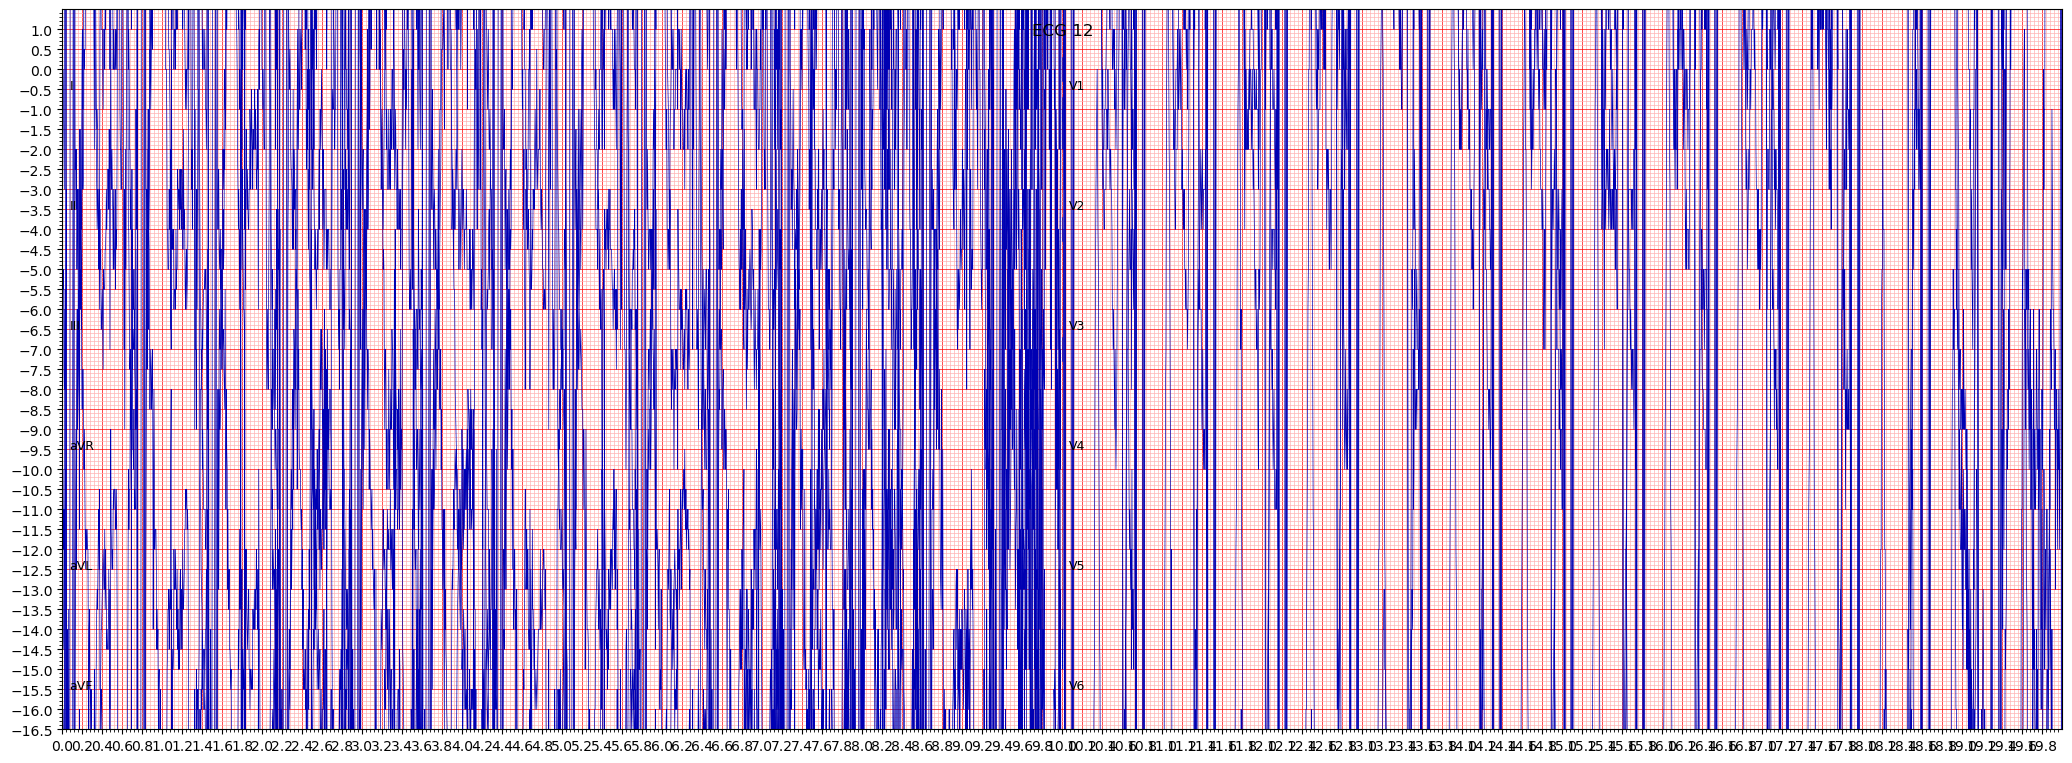

In [9]:
npy_array = np.load(df_output["npy_path"][0])
# Transpose the array to shape=[12, 2500]
ecg_transposed = np.transpose(npy_array, (1, 0, 2))
ecg_transposed = ecg_transposed.reshape(12, 2500)

import ecg_plot

ecg_plot.plot(ecg_transposed, sample_rate=250, title="ECG 12")
ecg_plot.show()

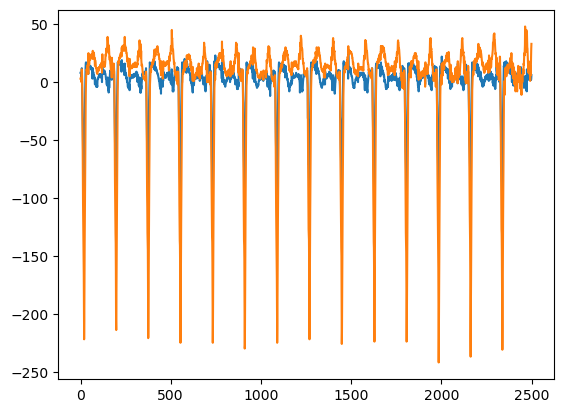

In [11]:
## Plot line of ecg_transposed[0] and ecg_transposed[1]
import matplotlib.pyplot as plt

plt.plot(ecg_transposed[0])
plt.plot(ecg_transposed[1])
plt.show()